In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

from sklearn import metrics

from sklearn.feature_extraction import text
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import wordcloud, string, nltk
from wordcloud import WordCloud, STOPWORDS

from gensim.models import Phrases
from collections import Counter

In [2]:
df = pd.read_csv('labeled_df.csv', header = 0)
df.drop(['Tweet'], axis = 1, inplace = True)
df.columns = ['Tweet', 'Spam']
df.replace(np.nan, 0, inplace=True)
df.tail()

,Tweet,Spam
395,rapidly global reserve just like dollar fiat c...,0.0
396,want earn big free join product earn fully,1.0
397,want send experienced trader journey wallet op...,0.0
398,rapid development project project pleasing tea...,1.0
399,wout weghorst primary market season level seri...,1.0


In [3]:
df.shape

(400, 2)

In [4]:
stop_words = list(text.ENGLISH_STOP_WORDS)
stop_words.extend(['ethereum', 'bitcoin', 'nft', 'eth', 'get', 'weblink', 'btc', 'nfts', 'crypto', 'mx', 'mxs', 'tg', 'bnb', 'u', 'amp', 'technical', 'analysis', 
                   'movement', 's', 'cryptocurrencies', 'cryptocurrency', 'sorare', 'breakout', 'shib', 'shibacoin', 'shiba', 'doge', 'dogecoin', 'blockchain', 'egld', 'xrp'])

lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
punc = list(set(string.punctuation))

def casual_tokenizer(text): #Splits words on white spaces (leaves contractions intact) and splits out trailing punctuation
    tokens = tokenizer.tokenize(text)
    return tokens

#Function to replace the nltk pos tags with the corresponding wordnet pos tag to use the wordnet lemmatizer
def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final
    
def process_text(text):
    tokenized = casual_tokenizer(text)
    lower = [item.lower() for item in tokenized]
    tagged = nltk.pos_tag(lower)
    lemma = lemma_wordnet(tagged)
    no_stop = [w for w in lemma if w not in stop_words]
    return no_stop

df['Tweet'] = df['Tweet'].apply(process_text)
df['Tweet'] = df['Tweet'].apply(' '.join)
df.head()

,Tweet,Spam
0,giddy ausae firm sell horse clinch deal virtual,0.0
1,zero chf eur use code teachin ch app usd use l...,0.0
2,awoniyi primary market season level serial price,1.0
3,people pay unrealized gain look lunatic genius...,0.0
4,activate payment purchase update mining council,0.0


## EDA

### Distribution of Ham vs Spam labeled tweets

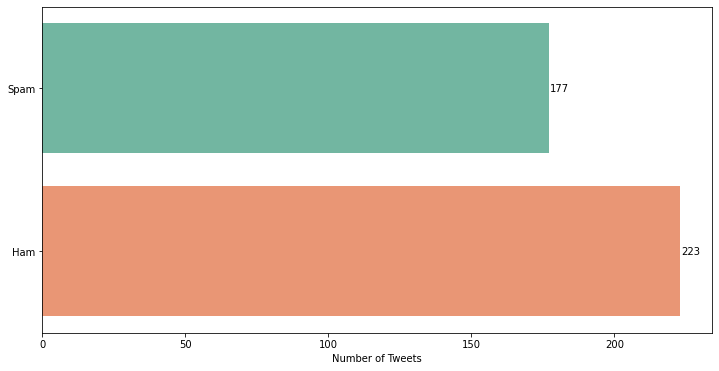

In [5]:
spam = df[df['Spam'] == 1]
ham = df[df['Spam'] == 0]

temp_df = pd.DataFrame([len(spam), len(ham)], ['Spam', 'Ham'], columns = ['Number of Tweets'])

plt.figure(figsize = (12, 6))
sns.set_palette('Set2')
ax = sns.barplot(x = temp_df['Number of Tweets'], y = temp_df.index)
ax.bar_label(ax.containers[0], padding=1)

plt.show()

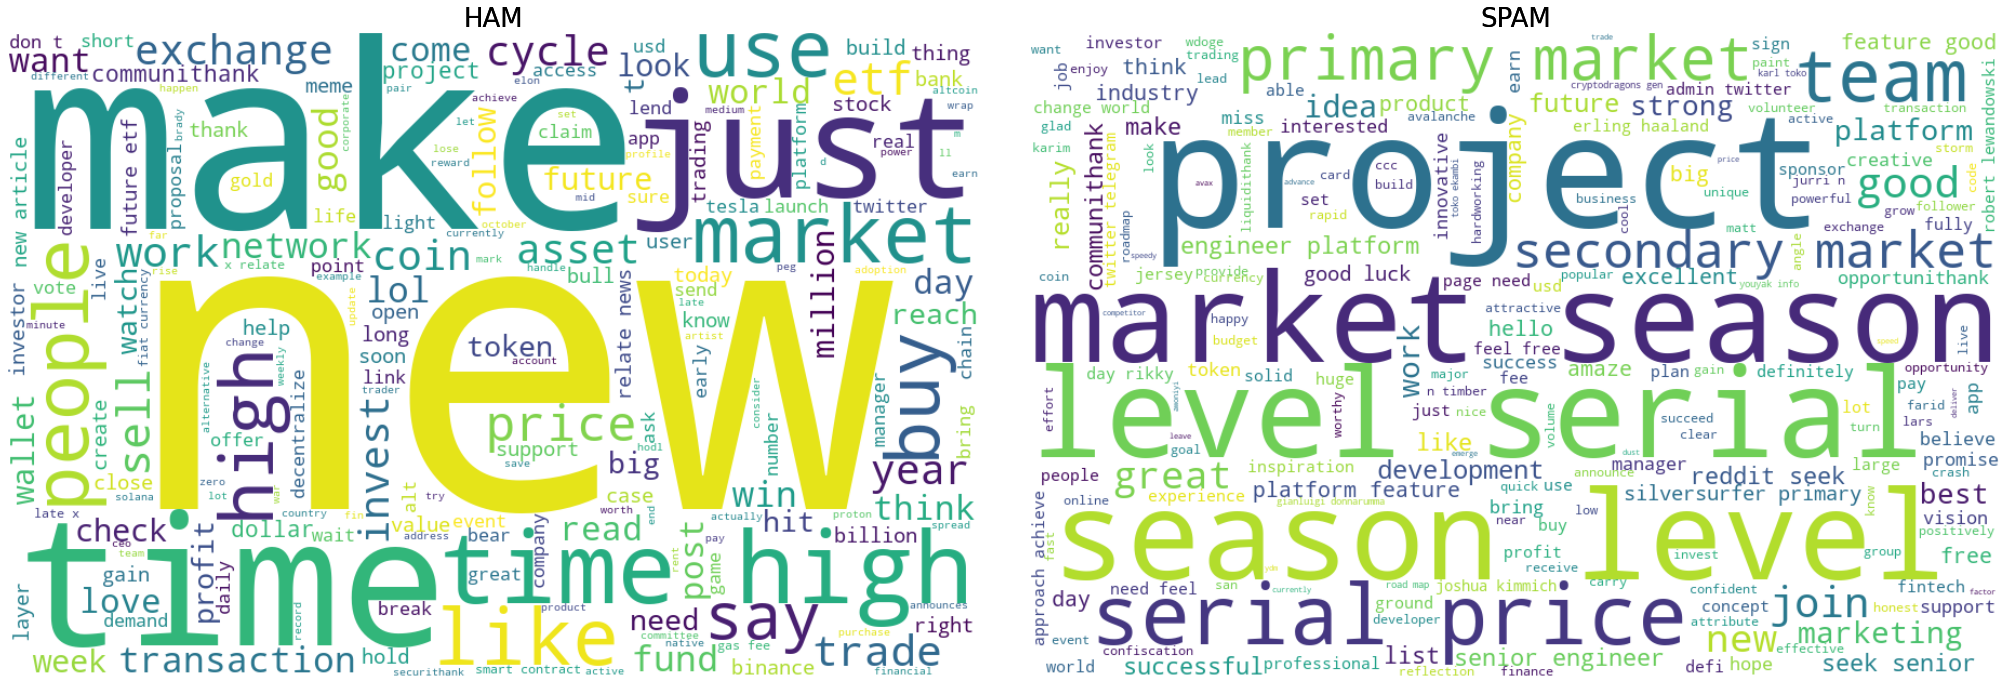

In [6]:
fig = plt.figure(num=12, figsize=(28, 20))
for i in enumerate(['HAM', 'SPAM']):
     
    # join all reviews with 
    ham_text = " ".join(tweet for tweet in ham['Tweet'])
    spam_text = " ".join(tweet for tweet in spam['Tweet'])

    ham_word_cloud = WordCloud(width = 900, height = 600, stopwords=stop_words, background_color="white").generate(ham_text)
    spam_word_cloud = WordCloud(width = 900, height = 600, stopwords=stop_words, background_color="white").generate(spam_text)
     
    fig.add_subplot(1, 2, 1)
    plt.imshow(ham_word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('HAM', fontsize = 26)
     
    fig.add_subplot(1, 2, 2)
    plt.imshow(spam_word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('SPAM', fontsize = 26)
     
    fig.tight_layout(w_pad = 5)
plt.show()

## Text Representation - creating the features (tfidf weights)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TFIDF converts a collection of raw documents to a matrix of TF-IDF features
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.01, max_df = 0.95, norm='l2', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(df['Tweet']).toarray()
labels = df['Spam']

print(features.shape)

(400, 239)


## Model Selection - test multiple classifiers to find one that performs the best

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(),
    GaussianNB(),
    SGDClassifier(random_state=3, loss='log')
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df.groupby('model_name').accuracy.mean()

model_name
GaussianNB                0.7925
KNeighborsClassifier      0.7650
LinearSVC                 0.9525
LogisticRegression        0.9300
MultinomialNB             0.9125
RandomForestClassifier    0.7950
SGDClassifier             0.9550
Name: accuracy, dtype: float64

## Multi-Class Classifier: Features and Design

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Spam'], random_state = 0, test_size=0.3)

X_train_counts = tfidf.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

pred = clf.predict(tfidf.transform(X_test))
score = metrics.accuracy_score(y_test, pred)

print('accuracy: %0.3f' % score)

accuracy: 0.925


## Confusion Matrix
The confusion matrix shows the ways in which classification model
is confused when it makes predictions.

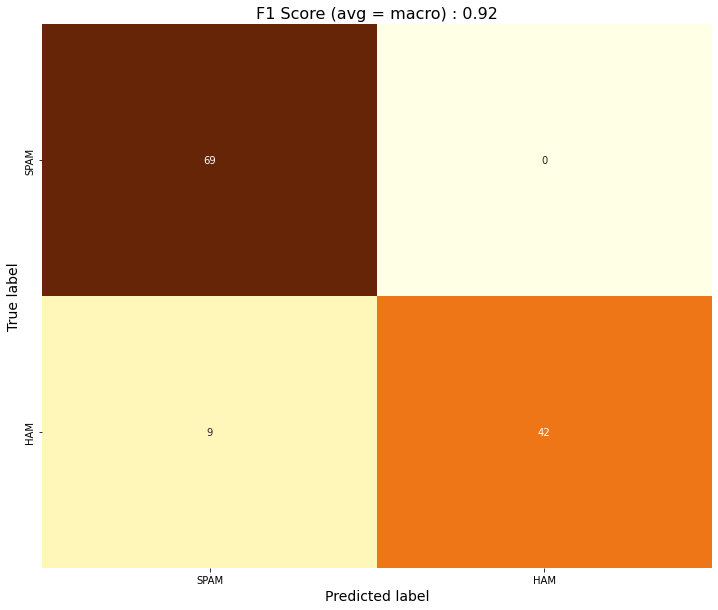

In [10]:
from sklearn.metrics import confusion_matrix, f1_score

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, pred) 

cm_df = pd.DataFrame(cm,
                     index = ['SPAM','HAM'], 
                     columns = ['SPAM','HAM'])

#Plot the heatmap using seaborn
plt.figure(figsize=(12, 10))

sns.heatmap(cm_df,
            annot=True, 
            cbar = False,  
            cmap='YlOrBr')

plt.title('F1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, pred, average='macro')), fontsize = 16)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

## Import test dataframe

In [11]:
test_df = pd.read_csv('test_df.csv')
test_df.drop(['Datetime', 'Tweet'], axis = 1, inplace = True)
test_df.columns = ['Tweet']
test_df['Tweet'] = test_df['Tweet'].apply(process_text)
test_df['Tweet'] = test_df['Tweet'].apply(' '.join)
test_df.head()

,Tweet
0,individual owner hodl new national bureau econ...
1,make lmao
2,lol volume profile sell make big
3,earn apy earn apy earnings sound appeal watch ...
4,just new collection collection just random art...


## Classify each Tweet in test_df

In [12]:
test_df['Spam'] = clf.predict(tfidf.transform(test_df['Tweet']))
test_df[['Tweet', 'Spam']].tail()

,Tweet,Spam
2329,minute entry signal time binance rentether dir...,0.0
2330,friend cheat sell tell corellation future tend...,0.0
2331,post phemex launch turkey platform appear coin...,0.0
2332,lot love earning rate kind pay,0.0
2333,faster space,0.0


## Distribution of Ham vs Spam

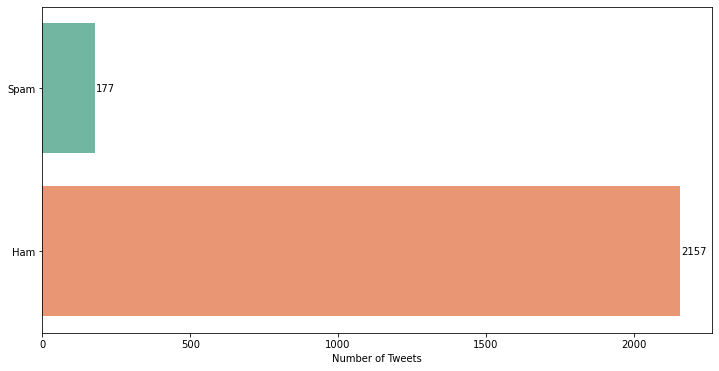

In [13]:
test_spam = test_df[test_df['Spam'] == 1.0]
test_ham = test_df[test_df['Spam'] != 1.0]

temp_df = pd.DataFrame([len(test_spam), len(test_ham)], ['Spam', 'Ham'], columns = ['Number of Tweets'])

sns.set_palette('Set2')
plt.figure(figsize = (12, 6))
ax = sns.barplot(x = temp_df['Number of Tweets'], y = temp_df.index)
ax.bar_label(ax.containers[0], padding=1)

plt.show()

### Wordclouds for Ham and Spam Tweets

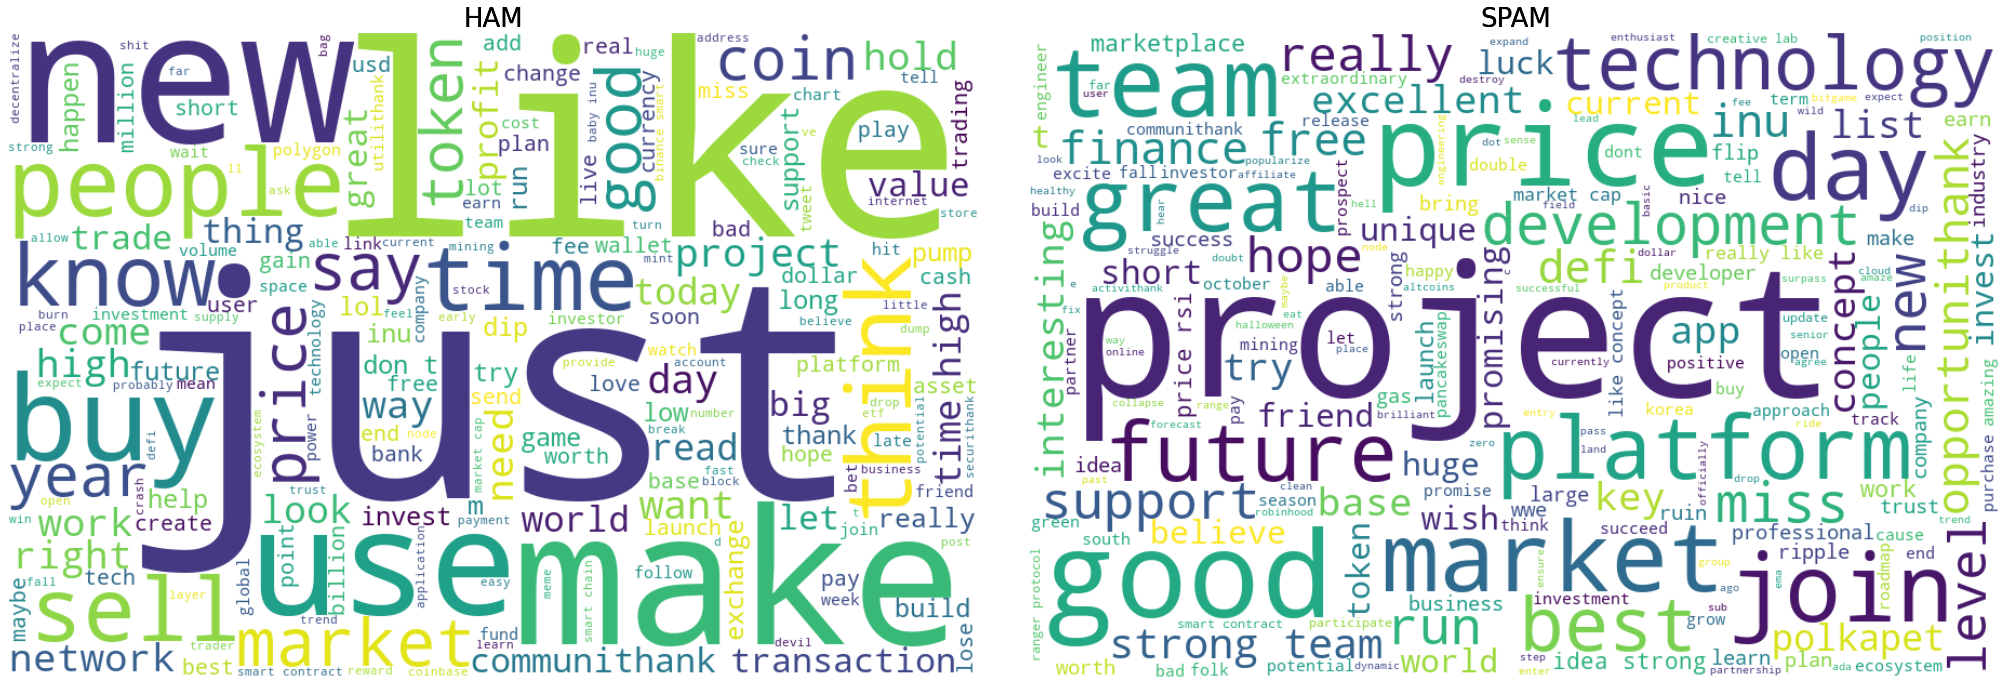

In [14]:
fig = plt.figure(num=12, figsize=(28, 20))
for i in enumerate(['HAM', 'SPAM']):
     
    # join all reviews with 
    ham_text = " ".join(tweet for tweet in test_ham['Tweet'])
    spam_text = " ".join(tweet for tweet in test_spam['Tweet'])

    ham_word_cloud = WordCloud(width = 900, height = 600, stopwords=stop_words, background_color="white").generate(ham_text)
    spam_word_cloud = WordCloud(width = 900, height = 600, stopwords=stop_words, background_color="white").generate(spam_text)
     
    fig.add_subplot(1, 2, 1)
    plt.imshow(ham_word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('HAM', fontsize = 26)
     
    fig.add_subplot(1, 2, 2)
    plt.imshow(spam_word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('SPAM', fontsize = 26)
     
    fig.tight_layout(w_pad = 5)
plt.show()

## Find top 15 words for each class and calculate their frequency

In [15]:
def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist.split()]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    df = pd.DataFrame([word, num]).T
    df.columns = ['Word', 'Frequency']
    return df.sort_values('Frequency')

spam_freq = word_freq(test_spam['Tweet'].values.tolist(), 15)
ham_freq = word_freq(test_ham['Tweet'].values.tolist(), 15)

## Add new column to test dataframe with number of words for each row

In [17]:
def word_count(text):
    return len(str(text).split(' '))

test_spam['word_count'] = test_spam['Tweet'].apply(word_count)
test_ham['word_count'] = test_ham['Tweet'].apply(word_count)

/var/folders/6_/m92t97hn6nlbq0gmnbq7229w0000gn/T/ipykernel_20151/2660336540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spam['word_count'] = test_spam['Tweet'].apply(word_count)
/var/folders/6_/m92t97hn6nlbq0gmnbq7229w0000gn/T/ipykernel_20151/2660336540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ham['word_count'] = test_ham['Tweet'].apply(word_count)


## Visualize most common words and distribution of word counts

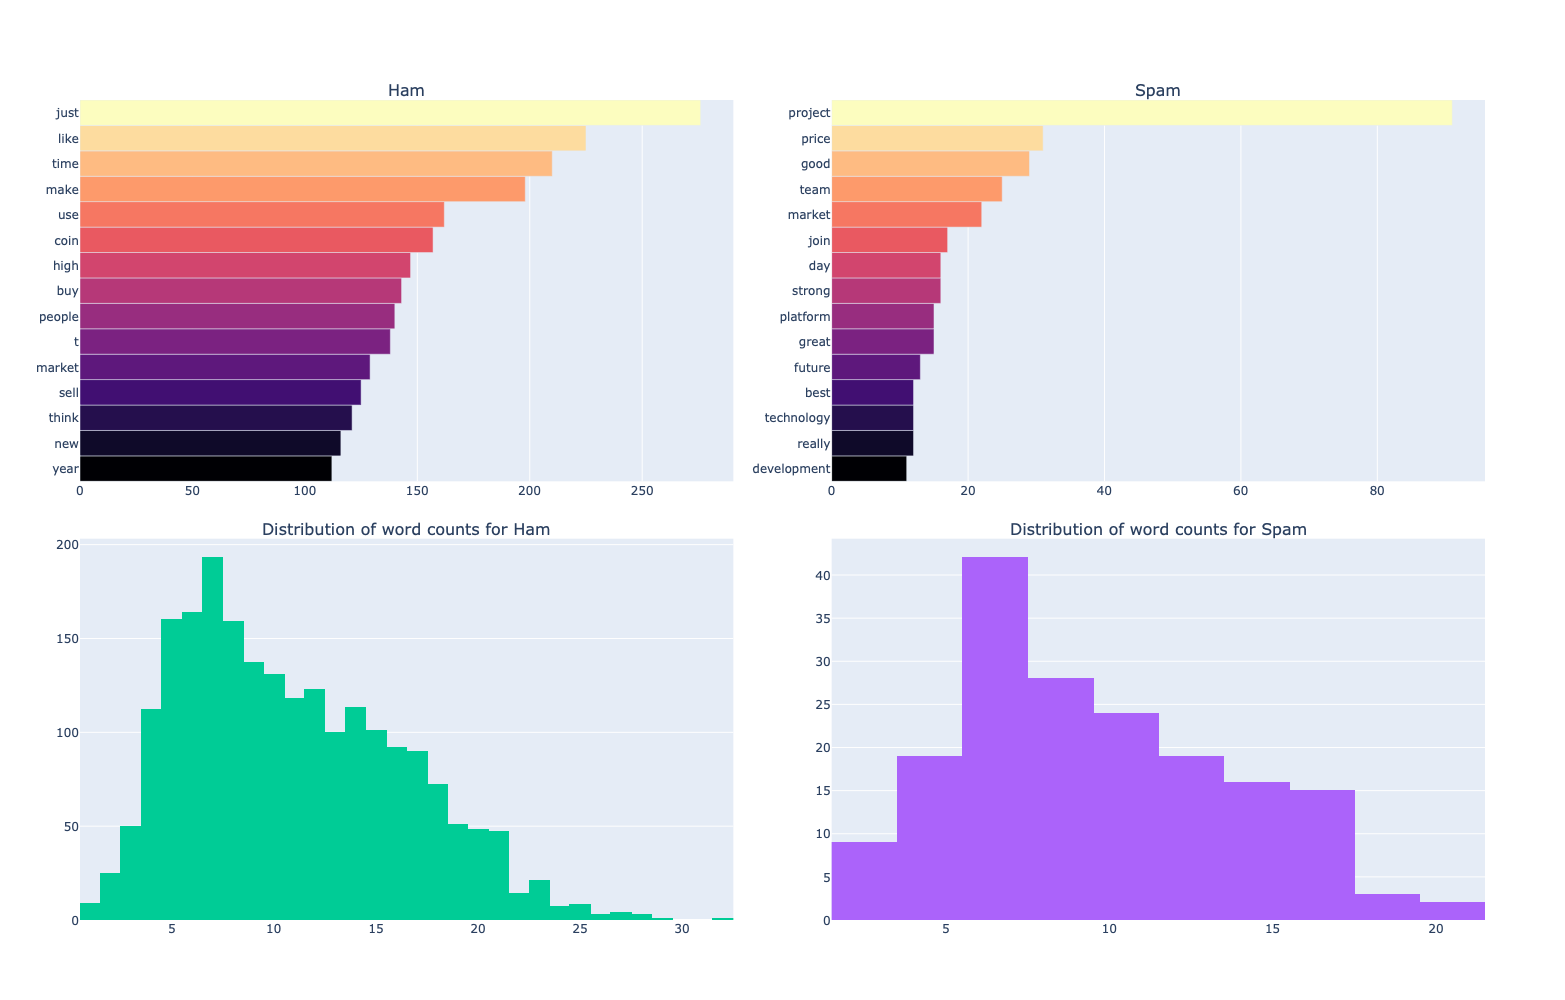

In [21]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Ham", 
                                                    "Spam", 
                                                    "Distribution of word counts for Ham", 
                                                    "Distribution of word counts for Spam"), 
                    horizontal_spacing = 0.07, vertical_spacing = 0.07)

fig.add_trace(go.Bar(x=ham_freq["Frequency"].values, y=ham_freq["Word"].values, 
                     marker={'color': list(range(len(ham_freq))), 'colorscale': 'magma'}, orientation= 'h'),
              1, 1)

fig.add_trace(go.Bar(x=spam_freq["Frequency"].values, y=spam_freq["Word"].values,
                    marker={'color': list(range(len(spam_freq))), 'colorscale': 'magma'}, orientation= 'h'),
              1, 2)
fig.add_trace(go.Histogram(x = test_ham["word_count"].values),
              2, 1)
fig.add_trace(go.Histogram(x = test_spam["word_count"].values),
              2, 2)

fig.update_coloraxes(showscale=False)
fig.update_layout(
    showlegend=False,
    width=1700,
    height=1000)
fig.show()

### Sample of Spam tweets

In [22]:
test_spam['Tweet'].tolist()[:10]

['reignman glad hear offend felt really bad',
 'daily basic bullish trend strong elrond usd short term sign run steam purchase',
 'prpject strong project technology really like concept project good idea strong team support project',
 'interesting promising company doubt project lead place communithank join unique project',
 'vechain partner rui shippai cause volume double break price',
 'try beef compliance weed bad actor hope authority comfort parthank oversight',
 'future price forecast forecast oct cet oct cet predict price range',
 'folks buckle hell ride way good luck',
 'team make strong effort order place project best position world great sense responsibilithank make step project',
 'project implement professionally clear development plan make professional experienced team doubt best project definitely huge wi']

### Sample of Not-Spam Tweets

In [23]:
test_ham['Tweet'].tolist()[:10]

['individual owner hodl new national bureau economic research study',
 'make lmao',
 'lol volume profile sell make big',
 'earn apy earn apy earnings sound appeal watch accompany video use referral hi earnings',
 'just new collection collection just random art available network right peice add sell',
 'meteoric rise social consensus new sov coin quickly compete exist sov coin like',
 'outperforms rally new time high',
 'intricately plan press release help earn credibilithank trust brand translates high conversion rate plan business great avenusa incorporate best press release service agency',
 'pantera ceo hit halve news',
 'hey just send message check dm']